<a href="https://colab.research.google.com/github/btiv/stock-trend-prediction/blob/master/Price_Trend_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2020 Brendan Tivnan
#
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# NOTICE: THIS FILE HAS BEEN MODIFIED BY Brendan Tivnan UNDER COMPLIANCE 
# WITH THE APACHE 2.0 LICENCE FROM THE ORIGINAL WORK OF THE COMPANY 
# Google LLC.

In [1]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


the label will be the delta between the close and open price, a positive delta indicates an increase of price, a negative indicates a decrease. The features
will be volume, stochastic oscillator, relative strength index, the 
aroon indicator and the previous days delta

In [13]:
# data collection


# get the price data for a given stock, IBM default

price_data = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")

# compute the delta

price_data["delta"] = price_data["close"] - price_data["open"]

# scale volume

price_data["volume"] = price_data["volume"] / 100000

# collect other feature data

stoch_data = pd.read_csv("https://www.alphavantage.co/query?function=STOCH&symbol=IBM&interval=daily&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")
rsi_data = pd.read_csv("https://www.alphavantage.co/query?function=RSI&symbol=IBM&interval=daily&time_period=10&series_type=open&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")
aroon_data = pd.read_csv("https://www.alphavantage.co/query?function=AROON&symbol=IBM&interval=daily&time_period=14&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")

In [14]:
# drop the first value to offset label and features
stoch_data = stoch_data.iloc[1:]
rsi_data = rsi_data.iloc[1:]
aroon_data = aroon_data.iloc[1:]

# add feature data to price data frame

price_data["SlowD"] = stoch_data["SlowD"]
price_data["SlowK"] = stoch_data["SlowK"]
price_data["RSI"] = rsi_data["RSI"]
price_data["AroonDown"] = aroon_data["Aroon Down"]
price_data["AroonUp"] = aroon_data["Aroon Up"]
price_data["PreviousDelta"] = price_data["delta"]

# shift data up

price_data["SlowD"] = price_data["SlowD"].shift(-1)
price_data["SlowK"] = price_data["SlowK"].shift(-1)
price_data["RSI"] = price_data["RSI"].shift(-1)
price_data["AroonDown"] = price_data["AroonDown"].shift(-1)
price_data["AroonUp"] = price_data["AroonUp"].shift(-1)
price_data["PreviousDelta"] = price_data["PreviousDelta"].shift(-1)

print(price_data)

# delete rows with empty cells

price_data.dropna(subset=["SlowD", "SlowK", "RSI", "AroonDown", "AroonUp", "PreviousDelta"], inplace=True)

#shuffle the examples and then split into training and test sets

price_data = price_data.reindex(np.random.permutation(price_data.index))

train_df = price_data.iloc[:4229, :]
test_df = price_data.iloc[4229:5000, :]
validation_df = price_data.iloc[5000:, :]

print(train_df)

       timestamp    open    high  ...  AroonDown   AroonUp  PreviousDelta
0     2020-09-04  124.35  125.35  ...    85.7143  100.0000          -3.74
1     2020-09-03  128.19  129.95  ...    92.8571  100.0000           4.46
2     2020-09-02  123.72  128.70  ...   100.0000    0.0000           0.55
3     2020-09-01  122.85  123.95  ...    57.1429    0.0000          -1.94
4     2020-08-31  125.25  125.25  ...    64.2857    7.1429           0.11
...          ...     ...     ...  ...        ...       ...            ...
5241  1999-11-05   92.75   92.94  ...        NaN       NaN          -2.88
5242  1999-11-04   94.44   94.44  ...        NaN       NaN          -1.50
5243  1999-11-03   95.87   95.94  ...        NaN       NaN          -1.94
5244  1999-11-02   96.75   96.81  ...        NaN       NaN          -1.75
5245  1999-11-01   98.50   98.81  ...        NaN       NaN            NaN

[5246 rows x 13 columns]
       timestamp    open    high  ...  AroonDown   AroonUp  PreviousDelta
2889  2009-0

In [16]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent volume.
volume = tf.feature_column.numeric_column("volume")
feature_columns.append(volume)

# Create a numerical feature column to represent SlowD.
slowd = tf.feature_column.numeric_column("SlowD")
feature_columns.append(slowd)

# Create a numerical feature column to represent SlowK.
slowk = tf.feature_column.numeric_column("SlowK")
feature_columns.append(slowk)

# Create a numerical feature column to represent RSI.
rsi = tf.feature_column.numeric_column("RSI")
feature_columns.append(rsi)

# Create a numerical feature column to represent Aroon Down.
aroon_down = tf.feature_column.numeric_column("AroonDown")
feature_columns.append(aroon_down)

# Create a numerical feature column to represent Aroon Up.
aroon_up = tf.feature_column.numeric_column("AroonUp")
feature_columns.append(aroon_up)

# Create a numerical feature column to represent the previous days delta.
previous_delta = tf.feature_column.numeric_column("PreviousDelta")
feature_columns.append(previous_delta)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
my_feature_layer = layers.DenseFeatures(feature_columns)

In [17]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.95, rmse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [49]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 4 nodes.   
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 4 nodes.   
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden2'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [50]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse

Epoch 1/1000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
43/43 [==============================] - 0s 4ms/step - loss: 10.4338 - root_mean_squared_error: 3.2301
Epoch 2/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.5776 - root_mean_squared_error: 1.6055
Epoch 3/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.5069 - root_mean_squared_error: 1.5833
Epoch 4/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.4468 - root_mean_squared_error: 1.5642
Epoch 5/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.5437 - root_mean_squared_error: 1.5949
Epoch 6/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.6835 - root_mean_squared_error: 1.6381
Epoch 7/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.4085 - root_mean_squared_error: 1.5519
Epoch 8/1000
43/43 [==============================] - 0s 4ms/step - loss: 2.4594 - r

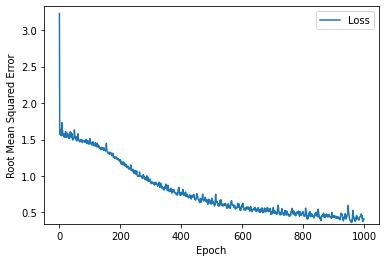


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
8/8 [==============================] - 0s 2ms/step - loss: 4.0586 - root_mean_squared_error: 2.0146


[4.058586597442627, 2.0145933628082275]

In [53]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 1000
batch_size = 100
label_name = "delta"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, rmse = train_model(my_model, train_df, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, rmse)

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [54]:
# make a prediction and compare to true value

validation_features = {name:np.array(value) for name, value in validation_df.items()}

print(validation_features)

predictions = my_model.predict(validation_features)

print(predictions)

# model only doing all positive or all negative for all predictions

{'timestamp': array(['2006-08-04', '2007-09-04', '2012-10-01', '2019-02-22',
       '2004-08-06', '2016-01-04', '2001-08-31', '2000-02-01',
       '2000-10-11', '2014-12-03', '2013-09-10', '2014-06-09',
       '2009-12-18', '2005-04-18', '2006-02-09', '2015-07-20',
       '2009-09-11', '2018-11-01', '2019-05-22', '2013-04-18',
       '2015-09-03', '2013-02-06', '2011-08-08', '2002-07-02',
       '2010-05-19', '2015-02-25', '2001-03-14', '2007-08-06',
       '2001-08-15', '2005-03-02', '2004-09-10', '2001-12-05',
       '2005-12-02', '2012-11-19', '2017-03-24', '2017-04-21',
       '2005-03-09', '2000-02-15', '2019-05-15', '2007-04-17',
       '2011-01-21', '2008-03-10', '2004-03-16', '2006-09-01',
       '2010-03-04', '2016-01-08', '2010-05-06', '2010-05-25',
       '2016-12-21', '2006-01-26', '2014-07-24', '2019-08-23',
       '2016-03-21', '2015-03-18', '2011-08-18', '2008-08-21',
       '2001-11-21', '2006-06-06', '2017-07-07', '2003-11-25',
       '2002-01-31', '2012-03-20', '2010-